# Function interpolation - simulation study 

This notebook runs a simple simulation study comparing the performance of multidimensional interpolation methods.

Ultimately, the goal is to implement interpolation methods in *respy*, an open-source Python package for the estimation of dynamic discrete-choice models.

# Motivation




...

# Theoretical Framework

...

# Simulation study

## Import necessary packages:

In [1]:
%load_ext autoreload

import matplotlib.pyplot as plt
import numpy as np
from src.functions_to_approximate import borehole
from src.interpolate import evaluation_batch
from src.interpolate import get_corner_states
from src.interpolate import get_data
from src.interpolate import get_dims_state_grid
from src.interpolate import get_grids_indices
from src.interpolate import get_grids_values
from src.interpolate import get_not_interpolated_indicator_random
from src.interpolate import get_states_grid_dense
from src.interpolate import inputs_from_ids_batch
from src.interpolate import inputs_from_state
from src.interpolate import interpolate_linear
from src.interpolate import mse as mean_squared_error
from src.interpolate import state_from_id
from src.interpolate import state_to_id
from src.interpolate import states_from_ids_batch
from src.interpolate import states_to_ids_batch

## Load default parameters

In [2]:
# default parameters for simulation study
grid_min_defaults = np.array(
    object=[63070.0, 990.0, 700.0, 100.0, 0.05, 1120.0, 1500.0, 63.1], dtype=float,
)
grid_max_defaults = np.array(
    object=[115600.0, 1110.0, 820.0, 50000.0, 0.15, 1680.0, 15000.0, 116.0],
    dtype=float,
)

n_gridpoints_dim_params = {}
n_gridpoints_dim_params["small"] = 5
n_gridpoints_dim_params["medium"] = 10
n_gridpoints_dim_params["large"] = 100

grid_density_params = {}
grid_density_params["small"] = np.array(object=[0, 1, 2, 3, 4, 5])
grid_density_params["medium"] = np.array(object=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
grid_density_params["large"] = np.array(
    object=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
)

vars_params = {}
vars_params["small"] = [2, 3, 4, 5]
vars_params["medium"] = [2, 3, 4, 5]
vars_params["large"] = [2]

## Set parameters for simulation study

In [4]:
seed = 123
load_data = True
grid_size = "small"

...

In [5]:
n_gridpoints_dim = n_gridpoints_dim_params[grid_size]
grid_density = grid_density_params[grid_size]
vars = vars_params[grid_size]

n_gridpoints_defaults = np.array(object=[n_gridpoints_dim] * 8, dtype=int,)

interpolation_points = {}
for n_vars in vars:
    interpolation_points[n_vars] = (grid_density * (n_gridpoints_dim ** (n_vars-1))).tolist()

In [6]:
print(interpolation_points)

{2: [0, 5, 10, 15, 20, 25], 3: [0, 25, 50, 75, 100, 125], 4: [0, 125, 250, 375, 500, 625], 5: [0, 625, 1250, 1875, 2500, 3125]}


In [7]:
iterations = list(range(len(grid_density)))

mse = {}
interpolation_points_effective = {}

for n_vars in vars:
    n_state_variables = n_vars

    n_gridpoints = n_gridpoints_defaults[:n_state_variables]
    grid_min = grid_min_defaults[:n_state_variables]
    grid_max = grid_max_defaults[:n_state_variables]

    n_states = n_gridpoints.prod()

    mse_tmp = []
    interpolation_points_effective_tmp = []

    for iteration in iterations:
        print(f"iteration: {iteration}; number of variables: {n_vars}")
        n_interpolation_points = interpolation_points[n_vars][iteration]

        dims_state_grid = get_dims_state_grid(n_state_variables, n_gridpoints)
        grids_values = get_grids_values(dims_state_grid, grid_min, grid_max)

        n_states = dims_state_grid.prod()
        states_index = np.array(object=range(n_states), dtype=int)
        states = states_from_ids_batch(states_index, dims_state_grid)
        results = evaluation_batch(states, grids_values)

        index = np.array(object=range(n_states))
        not_interpolated = get_not_interpolated_indicator_random(
            n_interpolation_points, n_states, seed
        )

        print("get interpolation basis")
        corner_states = get_corner_states(dims_state_grid)
        corner_index = states_to_ids_batch(corner_states, dims_state_grid)
        basis_index = np.unique(
            np.concatenate((index[not_interpolated], corner_index))
        )
        basis_points = inputs_from_ids_batch(
            basis_index, dims_state_grid, grids_values
        )
        basis_results = results[basis_index]

        print("get interpolation points")
        not_interpolated = np.in1d(index, basis_index)
        interpolated = np.logical_not(not_interpolated)
        index_not_interpolated = index[not_interpolated]
        index_interpolated = index[interpolated]
        inputs = inputs_from_ids_batch(
            index_interpolated, dims_state_grid, grids_values
        )

        print("interpolate")
        predict = interpolate_linear(inputs, basis_points, basis_results)
        results_predicted = np.full_like(results, np.nan)
        results_predicted[not_interpolated] = results[not_interpolated]
        results_predicted[interpolated] = predict
        results_calculated = results

        print("calculate mean squared error")
        mse_iter = mean_squared_error(results_predicted, results_calculated)
        mse_tmp.append(mse_iter)

        interpolation_points_effective_tmp.append(len(basis_index))

    mse[n_vars] = np.array(object=mse_tmp)
    interpolation_points_effective[n_vars] = np.array(
        object=interpolation_points_effective_tmp
    )

print("interpolation complete")

iteration: 0; number of variables: 2
get interpolation basis
get interpolation points
interpolate
calculate mean squared error
iteration: 1; number of variables: 2
get interpolation basis
get interpolation points
interpolate
calculate mean squared error
iteration: 2; number of variables: 2
get interpolation basis
get interpolation points
interpolate
calculate mean squared error
iteration: 3; number of variables: 2
get interpolation basis
get interpolation points
interpolate
calculate mean squared error
iteration: 4; number of variables: 2
get interpolation basis
get interpolation points
interpolate
calculate mean squared error
iteration: 5; number of variables: 2
get interpolation basis
get interpolation points
interpolate
calculate mean squared error
iteration: 0; number of variables: 3
get interpolation basis
get interpolation points
interpolate
calculate mean squared error
iteration: 1; number of variables: 3
get interpolation basis
get interpolation points
interpolate
calculate mea

In [8]:
print(mse)

{2: array([1.16297227e-10, 7.73656025e-11, 5.70148687e-11, 2.30639637e-12,
       1.13256826e-12, 0.00000000e+00]), 3: array([2.22628314e-10, 4.90331304e-11, 3.37867597e-11, 5.83973883e-12,
       3.26716674e-12, 0.00000000e+00]), 4: array([1.43189982e-03, 2.12970441e-04, 8.87126508e-05, 4.84834642e-05,
       3.18754793e-05, 0.00000000e+00]), 5: array([86.47001962,  5.51067626,  2.46586576,  1.15209044,  0.47468751,
        0.        ])}


In [9]:
print(interpolation_points_effective)

{2: array([ 4,  9, 13, 17, 20, 25]), 3: array([  8,  29,  52,  75, 100, 125]), 4: array([ 16, 135, 256, 378, 501, 625]), 5: array([  32,  653, 1270, 1885, 2505, 3125])}


# Plot results

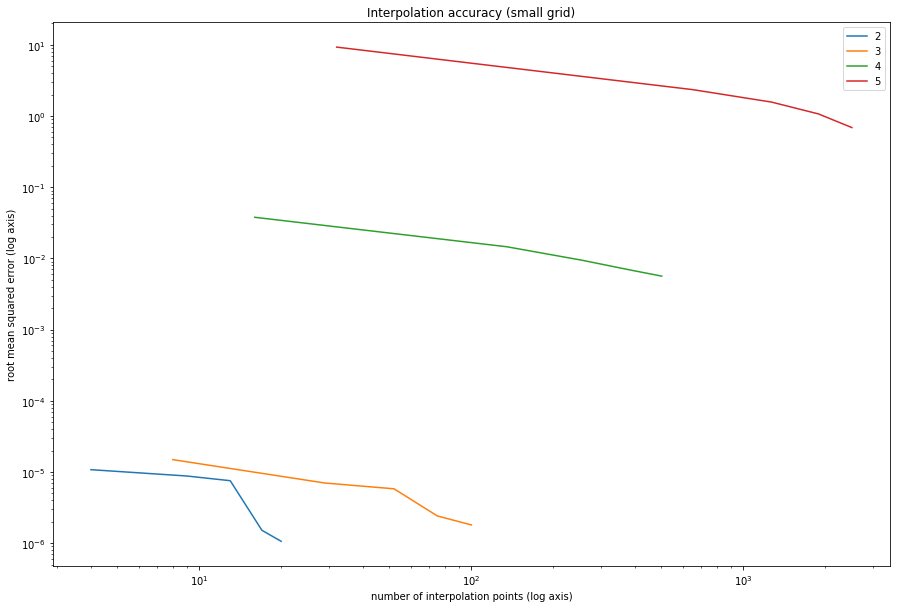

In [10]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

plot_legend = []
plot_x = []
plot_y = []
for n_vars in vars:
    plot_legend.append(n_vars)
    plot_x.append(interpolation_points_effective[n_vars][:-1])
    plot_y.append(np.sqrt(mse[n_vars][:-1]))

for idx in range(len(vars)):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title("Interpolation accuracy (" + grid_size + " grid)")
plt.show()

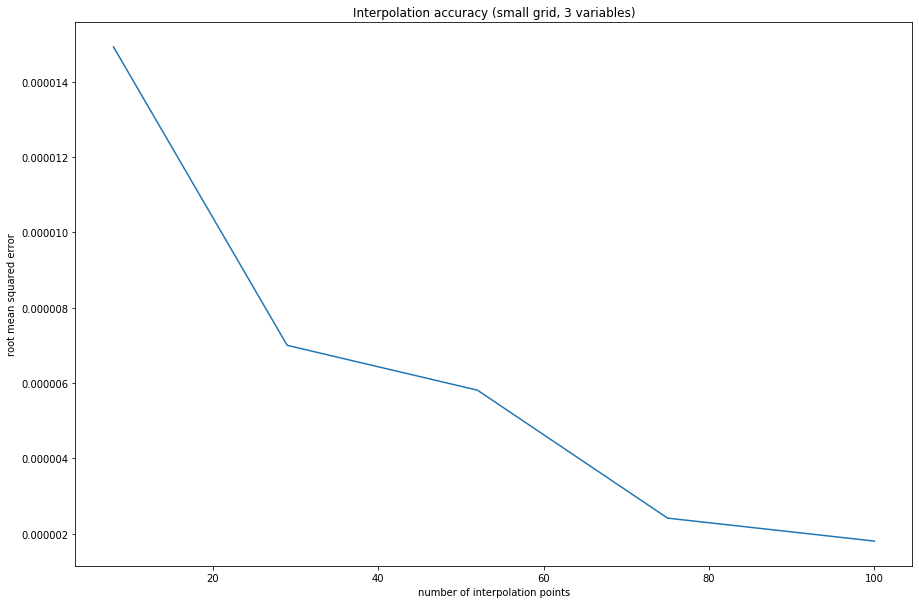

In [11]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(plot_x[1], plot_y[1])

plt.xlabel("number of interpolation points")
plt.ylabel("root mean squared error")
plt.title("Interpolation accuracy (" + grid_size + " grid, 3 variables)")
plt.show()

# References

...